In [ ]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzip dataset on runtime session

In [ ]:
!unzip '/content/drive/My Drive/CSE331_ML_Project/dataset.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: valid/truck/n03632852_1173.png  
  inflating: valid/truck/n03632852_11766.png  
  inflating: valid/truck/n03632852_11887.png  
  inflating: valid/truck/n03632852_1191.png  
  inflating: valid/truck/n03632852_1192.png  
  inflating: valid/truck/n03632852_1195.png  
  inflating: valid/truck/n03632852_1207.png  
  inflating: valid/truck/n03632852_12128.png  
  inflating: valid/truck/n03632852_1214.png  
  inflating: valid/truck/n03632852_1237.png  
  inflating: valid/truck/n03632852_1248.png  
  inflating: valid/truck/n03632852_1261.png  
  inflating: valid/truck/n03632852_1264.png  
  inflating: valid/truck/n03632852_1292.png  
  inflating: valid/truck/n03632852_1313.png  
  inflating: valid/truck/n03632852_1319.png  
  inflating: valid/truck/n03632852_13311.png  
  inflating: valid/truck/n03632852_1355.png  
  inflating: valid/truck/n03632852_13648.png  
  inflating: valid/truck/n03632852_13730.png  
  inflating: valid/truck/n03632852_138

#Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math


class ShakeDropFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, training=True, p_drop=0.5, alpha_range=[-1, 1]):
        if training:
            gate = torch.cuda.FloatTensor([0]).bernoulli_(1 - p_drop)
            ctx.save_for_backward(gate)
            if gate.item() == 0:
                alpha = torch.cuda.FloatTensor(x.size(0)).uniform_(*alpha_range)
                alpha = alpha.view(alpha.size(0), 1, 1, 1).expand_as(x)
                return alpha * x
            else:
                return x
        else:
            return (1 - p_drop) * x

    @staticmethod
    def backward(ctx, grad_output):
        gate = ctx.saved_tensors[0]
        if gate.item() == 0:
            beta = torch.cuda.FloatTensor(grad_output.size(0)).uniform_(0, 1)
            beta = beta.view(beta.size(0), 1, 1, 1).expand_as(grad_output)
            beta = Variable(beta)
            return beta * grad_output, None, None, None
        else:
            return grad_output, None, None, None


class ShakeDrop(nn.Module):

    def __init__(self, p_drop=0.5, alpha_range=[-1, 1]):
        super(ShakeDrop, self).__init__()
        self.p_drop = p_drop
        self.alpha_range = alpha_range

    def forward(self, x):
        return ShakeDropFunction.apply(x, self.training, self.p_drop, self.alpha_range)





class ShakeBasicBlock(nn.Module):

    def __init__(self, in_ch, out_ch, stride=1, p_shakedrop=1.0):
        super(ShakeBasicBlock, self).__init__()
        self.downsampled = stride == 2
        self.branch = self._make_branch(in_ch, out_ch, stride=stride)
        self.shortcut = not self.downsampled and None or nn.AvgPool2d(2)
        self.shake_drop = ShakeDrop(p_shakedrop)

    def forward(self, x):
        h = self.branch(x)
        h = self.shake_drop(h)
        h0 = x if not self.downsampled else self.shortcut(x)
        pad_zero = Variable(torch.zeros(h0.size(0), h.size(1) - h0.size(1), h0.size(2), h0.size(3)).float()).cuda()
        h0 = torch.cat([h0, pad_zero], dim=1)

        return h + h0

    def _make_branch(self, in_ch, out_ch, stride=1):
        return nn.Sequential(
            nn.BatchNorm2d(in_ch),
            nn.Conv2d(in_ch, out_ch, 3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_ch))


class ShakePyramidNet(nn.Module):

    def __init__(self, depth=110, alpha=270, label=10):
        super(ShakePyramidNet, self).__init__()
        in_ch = 16
        # for BasicBlock
        n_units = (depth - 2) // 6
        in_chs = [in_ch] + [in_ch + math.ceil((alpha / (3 * n_units)) * (i + 1)) for i in range(3 * n_units)]
        block = ShakeBasicBlock

        self.in_chs, self.u_idx = in_chs, 0
        self.ps_shakedrop = [1 - (1.0 - (0.5 / (3 * n_units)) * (i + 1)) for i in range(3 * n_units)]

        self.c_in = nn.Conv2d(3, in_chs[0], 3, padding=1)
        self.bn_in = nn.BatchNorm2d(in_chs[0])
        self.layer1 = self._make_layer(n_units, block, 1)
        self.layer2 = self._make_layer(n_units, block, 2)
        self.layer3 = self._make_layer(n_units, block, 2)
        self.bn_out = nn.BatchNorm2d(in_chs[-1])
        self.fc_out = nn.Linear(in_chs[-1], label)

        # Initialize paramters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        h = self.bn_in(self.c_in(x))
        h = self.layer1(h)
        h = self.layer2(h)
        h = self.layer3(h)
        h = F.relu(self.bn_out(h))
        h = F.avg_pool2d(h, 8)
        h = h.view(h.size(0), -1)
        h = self.fc_out(h)
        return h

    def _make_layer(self, n_units, block, stride=1):
        layers = []
        for i in range(int(n_units)):
            layers.append(block(self.in_chs[self.u_idx], self.in_chs[self.u_idx+1],
                                stride, self.ps_shakedrop[self.u_idx]))
            self.u_idx, stride = self.u_idx + 1, 1
        return nn.Sequential(*layers)



#Utils

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## Hyperparameters

In [ ]:
SAVEPATH = '/content/drive/My Drive/CSE331_ML_Project/'
WEIGHTDECAY = 1e-4
MOMENTUM = 0.9
BATCHSIZE = 256
LR = 1e-07
EPOCHS = 400
PRINTFREQ = 100

#Data Augumentation

In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    normalize
    ])
train_transform2 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    normalize
    ])

valid_transform = transforms.Compose([transforms.ToTensor(),normalize])

# Load datasets
train_dataset = torchvision.datasets.ImageFolder('./train',transform=train_transform)
#train_dataset_flipped = torchvision.datasets.ImageFolder('./train',transform=train_transform2)
val_dataset = torchvision.datasets.ImageFolder('./valid',transform=train_transform)

#tval_dataset, rval_dataset = random_split(val_dataset, [54000, 36000], generator=torch.Generator().manual_seed(42))

train_d = train_dataset + val_dataset
#val_d = rval_dataset
print(len(train_d))
#print(len(val_d))
train_loader = DataLoader(train_d,
                        batch_size=BATCHSIZE, shuffle=True,
                        num_workers=4, pin_memory=True)

#val_loader = DataLoader(val_d, batch_size=BATCHSIZE, num_workers=4, shuffle=True)

180000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


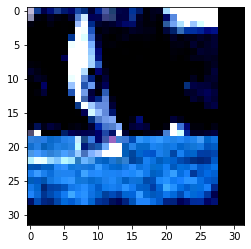

In [ ]:
import matplotlib.pyplot as plt
print(train_loader)
for i, (input, target) in enumerate(train_loader):
  #print(input)
  print(i)
  a = input[1]
  a = a.permute(1,2,0)
  plt.imshow(a)
  break


#Validation Parameters

In [ ]:
n_epochs_stop = 50 #patience
epochs_no_improve = 0
early_stop = False
min_val_loss = 999
val_loss=0

In [ ]:
import pandas as pd
epochs = [x for x in range(EPOCHS)]
train_stats = pd.DataFrame(index = epochs, columns = ['Train loss', 'Train accuracy','Valid loss', 'Valid accuracy']) 


In [ ]:
def shakePyramidNet():
	model = ShakePyramidNet(132, 45, 10)
	return model

## Train Model

In [ ]:
import time

def main():
    LR = 1e-8
    model = shakePyramidNet()
    model.load_state_dict(torch.load(SAVEPATH+"shake_pyramidnet_ver9.pth"))
    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.Adam(model.parameters(), lr=LR,
                                weight_decay=WEIGHTDECAY)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 20, 30, 40, 200, 300],
    #                                                 gamma=0.5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50, eta_min=0, last_epoch=-1, verbose=False)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda()
    criterion = criterion.cuda()

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")
    if int(pytorch_total_params) > 2000000:
        print('Your model has the number of parameters more than 2 millions..')
        return


    last_top1_acc = 0

    
    for epoch in range(EPOCHS):
      print("\n----- epoch: {}, lr: {} -----".format(
          epoch, optimizer.param_groups[0]["lr"]))

      # train for one epoch
      start_time = time.time()
      last_top1_acc = train(train_loader, epoch, model, optimizer, criterion)
      #last_top1_val_acc = valid(val_loader, epoch, model, criterion)
      elapsed_time = time.time() - start_time
      print('==> {:.2f} seconds to train this epoch\n'.format(
          elapsed_time))

      # learning rate scheduling
      #scheduler.step()

      # Save model each epoch
      torch.save(model.state_dict(), SAVEPATH + 'shake_pyramidnet_ver9.pth')
      train_stats.to_csv(SAVEPATH+'shake_pyramidnet_ver9.csv')

      #scheduler.step(min_val_loss)
      if early_stop:
        print("Stopped")
        break

    print(f"Last Top-1 Accuracy: {last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")

def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)
    train_stats.loc[epoch]['Train loss'] = losses.avg
    train_stats.loc[epoch]['Train accuracy'] = top1.avg

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg

def valid(val_loader, epoch, model, criterion):
  global n_epochs_stop
  global epochs_no_improve
  global early_stop
  global min_val_loss 
  global val_loss
  

  print("Try Validation...")
  model.eval()
  batch_time = AverageMeter('Time', ':6.3f')
  data_time = AverageMeter('Data', ':6.3f')
  losses = AverageMeter('Val Loss', ':.4e')
  top1 = AverageMeter('Val Acc@1', ':6.2f')
  top5 = AverageMeter('Val Acc@5', ':6.2f')
  progress = ProgressMeter(len(val_loader), batch_time, data_time, losses,
                            top1, top5, prefix="Epoch: [{}]".format(epoch))
  end = time.time()
  for i, (input, target) in enumerate(val_loader):
      # measure data loading time
      data_time.update(time.time() - end)

      input = input.cuda()
      target = target.cuda()

      # compute output
      output = model(input)
      loss = criterion(output, target)
      val_loss += loss.item()

      # measure accuracy and record loss, accuracy 
      acc1, acc5 = accuracy(output, target, topk=(1, 5))
      losses.update(loss.item(), input.size(0))
      top1.update(acc1[0].item(), input.size(0))
      top5.update(acc5[0].item(), input.size(0))
      # compute gradient and do SGD step
      # measure elapsed time
      batch_time.update(time.time() - end)
      end = time.time()

      if i % 100 * PRINTFREQ == 0:
          progress.print(i)
  train_stats.loc[epoch]['Valid loss'] = losses.avg
  train_stats.loc[epoch]['Valid accuracy'] = top1.avg

  val_loss = val_loss / len(val_loader)
  if val_loss < min_val_loss:
    min_val_loss = val_loss
    epochs_no_improve = 0
  else:
    epochs_no_improve += 1
    if epochs_no_improve == n_epochs_stop:
      print('Early stopping!')
      early_stop = True



  print('=> Vall Acc@1 {top1.avg:.3f} Val Acc@5 {top5.avg:.3f}'
        .format(top1=top1, top5=top5))
  print('Avg val_oss : {}'.format(val_loss))
  print("epoch_no_improve: {}" .format(epochs_no_improve))
  print("min val loss: {}" .format(min_val_loss))

  return top1.avg

if __name__ == "__main__":
    main()

Number of parameters: 1941541

----- epoch: 0, lr: 1e-08 -----
Epoch: [0][  0/704]	Time  1.431 ( 1.431)	Data  0.472 ( 0.472)	Loss 1.2624e-01 (1.2624e-01)	Acc@1  96.88 ( 96.88)	Acc@5 100.00 (100.00)
Epoch: [0][100/704]	Time  0.410 ( 0.416)	Data  0.000 ( 0.005)	Loss 1.1750e-01 (1.8498e-01)	Acc@1  95.70 ( 93.63)	Acc@5 100.00 ( 99.80)
Epoch: [0][200/704]	Time  0.414 ( 0.411)	Data  0.000 ( 0.003)	Loss 2.4585e-01 (1.8093e-01)	Acc@1  91.80 ( 93.71)	Acc@5  99.22 ( 99.83)
Epoch: [0][300/704]	Time  0.408 ( 0.410)	Data  0.000 ( 0.002)	Loss 1.2333e-01 (1.7881e-01)	Acc@1  93.75 ( 93.79)	Acc@5 100.00 ( 99.84)
Epoch: [0][400/704]	Time  0.406 ( 0.409)	Data  0.000 ( 0.001)	Loss 2.0163e-01 (1.8020e-01)	Acc@1  92.97 ( 93.74)	Acc@5 100.00 ( 99.84)
Epoch: [0][500/704]	Time  0.408 ( 0.409)	Data  0.000 ( 0.001)	Loss 2.2923e-01 (1.8016e-01)	Acc@1  90.62 ( 93.75)	Acc@5 100.00 ( 99.83)
Epoch: [0][600/704]	Time  0.411 ( 0.409)	Data  0.000 ( 0.001)	Loss 2.0818e-01 (1.7893e-01)	Acc@1  92.97 ( 93.79)	Acc@5 100.00 (

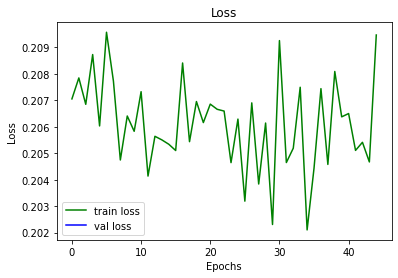

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(SAVEPATH+"shake_pyramidnet_ver9.csv")
ax = plt.axes()

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss");

x = range(1, len(data['Train loss'].values) + 1)
ax.plot(data.index, data['Train loss'].values, '-g', label='train loss');
ax.plot(data.index, data['Valid loss'].values, '-b', label='val loss');

plt.legend()




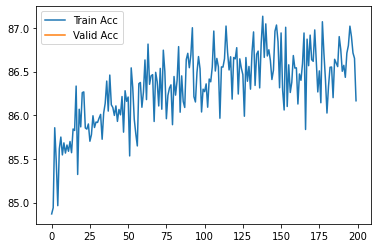

In [ ]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(figsize=(10,5))
ax.plot(data.index,data["Train accuracy"], label = 'Train Acc')
ax.plot(data.index,data["Valid accuracy"], label = 'Valid Acc')
ax.legend(loc='best')
ax.legend()


## Make an evalutation csv file

This code makes an evaluation csv file for kaggle submission.


In [ ]:
import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class TestImageFolder(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        # return image path
        return super(TestImageFolder, self).__getitem__(index), self.imgs[index][0].split('/')[-1]


def eval():
    ########## You can change this part only in this cell ##########
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    ################################################################

    test_dataset = TestImageFolder('./test', transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, num_workers=4, shuffle=False)

    model = shakePyramidNet()
    model = model.cuda()
    model.load_state_dict(torch.load(SAVEPATH+'shake_pyramidnet_ver9.pth'))
    model.eval()

    print('Make an evaluation csv file for kaggle submission...')
    Category = []
    Id = []
    for data in test_loader:
        (input, _), name = data
        
        input = input.cuda()
        output = model(input)
        output = torch.argmax(output, dim=1)
        Id = Id + list(name)
        Category = Category + output.tolist()

    #Id = list(range(0, 90000))
    samples = {
       'Id': Id,
       'Target': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Target'])

    df.to_csv(SAVEPATH+'submission_shake_pyramidnet_ver9_3-4.csv', index=False)
    print('Done!!')


if __name__ == "__main__":
    eval()

Make an evaluation csv file for kaggle submission...
Done!!
